In [2]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)


In [10]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, exploration_strategy="epsilon_greedy"):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.exploration_strategy = exploration_strategy

        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.update_target_network()

        self.gamma = 0.9
        self.epsilon = 1.0   # Start with high exploration
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 1e-3
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.replay_buffer = ReplayBuffer(10000)
        self.batch_size = 64

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def select_action(self, state):
        # Implement different exploration strategies
        if self.exploration_strategy == "epsilon_greedy":
            if random.random() < self.epsilon:
                return random.randint(0, self.action_dim - 1)
            else:
                state = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.model(state)
                return torch.argmax(q_values).item()
        elif self.exploration_strategy == "noisy_network":
            # Noisy Network exploration
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state)
            return torch.argmax(q_values).item()
        elif self.exploration_strategy == "ucb":
            # UCB-based exploration 
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state)
            return torch.argmax(q_values).item()
        else:
            raise ValueError("Unknown exploration strategy")

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Q-Learning targets
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0]
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss
        loss = nn.MSELoss()(q_values, targets)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [13]:
def train_dqn(agent, env, episodes=1000):
    rewards = []
    for episode in range(episodes + 1):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state

            agent.train()
            episode_reward += reward

            if done:
                rewards.append(episode_reward)
                agent.decay_epsilon()

        # Update the target network every 10 episodes
        if episode % 10 == 0:
            agent.update_target_network()
        
        # Print the episode's reward every 10 episodes
        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.3f}")
    
    return rewards

In [7]:
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('DQN on CartPole')
    plt.show()

Episode 0, Reward: 17.0, Epsilon: 0.995
Episode 10, Reward: 11.0, Epsilon: 0.946
Episode 20, Reward: 13.0, Epsilon: 0.900
Episode 30, Reward: 27.0, Epsilon: 0.856
Episode 40, Reward: 43.0, Epsilon: 0.814
Episode 50, Reward: 23.0, Epsilon: 0.774
Episode 60, Reward: 41.0, Epsilon: 0.737
Episode 70, Reward: 27.0, Epsilon: 0.701
Episode 80, Reward: 90.0, Epsilon: 0.666
Episode 90, Reward: 67.0, Epsilon: 0.634
Episode 100, Reward: 84.0, Epsilon: 0.603
Episode 110, Reward: 42.0, Epsilon: 0.573
Episode 120, Reward: 16.0, Epsilon: 0.545
Episode 130, Reward: 180.0, Epsilon: 0.519
Episode 140, Reward: 205.0, Epsilon: 0.493
Episode 150, Reward: 192.0, Epsilon: 0.469
Episode 160, Reward: 16.0, Epsilon: 0.446
Episode 170, Reward: 122.0, Epsilon: 0.424
Episode 180, Reward: 13.0, Epsilon: 0.404
Episode 190, Reward: 49.0, Epsilon: 0.384
Episode 200, Reward: 189.0, Epsilon: 0.365
Episode 210, Reward: 47.0, Epsilon: 0.347
Episode 220, Reward: 63.0, Epsilon: 0.330
Episode 230, Reward: 197.0, Epsilon: 0.3

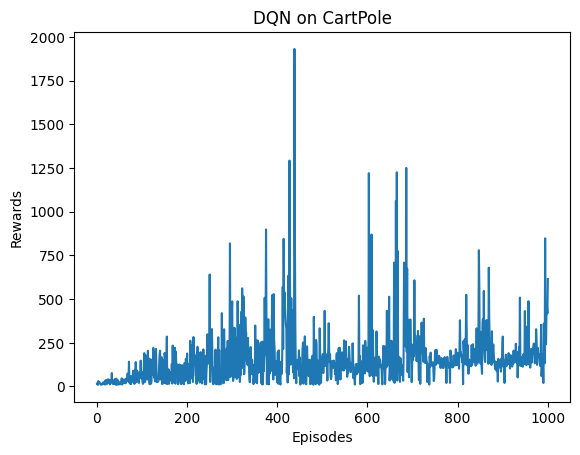

In [14]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize the agent
agent = DQNAgent(state_dim, action_dim, exploration_strategy="epsilon_greedy")

# Train the agent and plot the learning curve
rewards = train_dqn(agent, env)
plot_rewards(rewards)
env.close()